<a href="https://colab.research.google.com/github/huynhthedu/django-app/blob/main/Class_Project_Sentiment_Analysis_FA24_for_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Final Project Part 2: Sentiment Classification of Drug Review
  

Joycee Berin, Du Huynh, and Elizabeth Varghese

Department of Data Science, Indiana University

DSCI-D590: Intro to NLP for Data Science

Professor Olga Scrivner

Fall 2024


#2. Data Extraction


* Create a "Project" folder then a "data" subfolder containing the ZIP files to serve as the data source for this project
  * ZIP file source: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018?select=drugsComTrain_raw.csv
  * ZIP file source: https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018?select=drugsComTest_raw.csv
 * 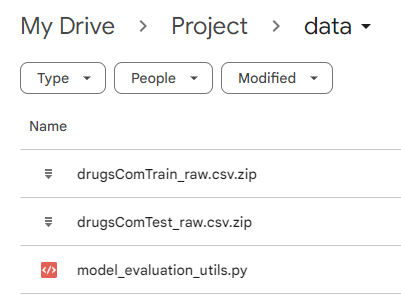
* Mount your google drive
* Unzip files
* Combine the contents of both zip files into a single dataframe, which will later be split into new training and testing datasets










In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

# Unzip files
dataset_test = pd.read_csv('/content/drive/My Drive/Project/data/drugsComTest_raw.csv.zip', compression='zip')
dataset_train = pd.read_csv('/content/drive/My Drive/Project/data/drugsComTrain_raw.csv.zip', compression='zip')

# Combine data sets
dataset_combined = pd.concat([dataset_test, dataset_train], ignore_index=True)

# Preview the contents of the columns
dataset_combined.head()


,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


#3. Preprocessing steps
*   Normalize corpus and preprocess the text by removing POS tags, removing special characters, stripping whitespaces, tokenization, removal of stopwords, filtering of non-alphabetical tokens, and lemmatization
* Process in batches (Connect to TPU to leverage optimized batch processing)
* Create ground truth label using rating column
* References: https://www.analyticsvidhya.com/blog/2021/05/how-to-use-progress-bars-in-python/

  https://blog.talent500.co/blog/batch-processing-handling-large-volumes-of-data-in-scheduled-or-periodic-batches/

  https://stackoverflow.com/questions/23926620/how-to-execute-a-for-loop-in-batches

In [ ]:
# Import libraries
import spacy
import re
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm  # For progress bar
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

wpt = nltk.WordPunctTokenizer()

stop_words = nltk.corpus.stopwords.words('english')

# Create functions for data cleansing and entire preprocessing pipeline

def clean_text(text):
    # Remove POS tags, special chars, convert to lowercase, strip whitespaces
    cleaned_text = re.sub(r'/[A-Z]+|&[a-z]+;|[^a-z\s]', '', text.lower().strip())
    return cleaned_text

def tokenize_and_filter_stopwords(text):
    tokens = word_tokenize(text)
    # Filter out tokens that are non-alphabetic or in stopwords
    filtered_tokens = [word for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return filtered_tokens

def lemmatize_text(tokens):

    # Lemmatizes, ensuring no stopwords are included
    doc = nlp(' '.join(tokens))
    lemmatized_words = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words and not token.is_stop]
    return lemmatized_words

def preprocess_review(text):
    # Full preprocessing pipeline using the above functions
    cleaned_text = clean_text(text)
    tokens = tokenize_and_filter_stopwords(cleaned_text)
    return lemmatize_text(tokens)

In [ ]:
# Set batch size for processing
batch_size = 1000

# Empty list to store processed reviews
processed_reviews = []

# Apply the preprocessing in batches to the review column of the combined dataset
for start in tqdm(range(0, len(dataset_combined), batch_size), desc="Processing Batches"):
    end = start + batch_size
    batch = dataset_combined['review'][start:end].apply(preprocess_review)
    # Join tokenized lists into strings
    processed_reviews.extend([' '.join(review) if isinstance(review, list) else review for review in batch])

# Add processed reviews to dataset
dataset_combined['cleaned_review'] = processed_reviews

# Preview the preprocessed data with new cleaned_review column
print("Processed Reviews:\n", dataset_combined[['review', 'cleaned_review']].head())

Processing Batches: 100%|██████████| 216/216 [25:09<00:00,  6.99s/it]

Processed Reviews:
                                               review  \
0  "I&#039;ve tried a few antidepressants over th...   
1  "My son has Crohn&#039;s disease and has done ...   
2                      "Quick reduction of symptoms"   
3  "Contrave combines drugs that were used for al...   
4  "I have been on this birth control for one cyc...   

                                      cleaned_review  
0  try antidepressant year citalopram fluoxetine ...  
1  son crohns disease asacol complaint show effec...  
2                            quick reduction symptom  
3  contrave combine drug alcohol smoke opioid ces...  
4  birth control cycle read review type similar b...  


In [ ]:
# Function to map rating to ground truth label
def map_rating_to_actual_sentiment(rating):
    if rating >= 1 and rating <= 3:
        return 'negative'
    elif rating >= 4 and rating <= 7:
        return 'neutral'
    elif rating >= 8 and rating <= 10:
        return 'positive'

In [ ]:
# Create a new ground_truth column based on the rating column
dataset_combined['ground_truth'] = dataset_combined['rating'].apply(map_rating_to_actual_sentiment)

# Preview new ground_truth column
print(dataset_combined[['rating', 'ground_truth']].head())

   rating ground_truth
0      10     positive
1       8     positive
2       9     positive
3       9     positive
4       9     positive


# 4. Exploratory Data Analysis


##4.1. Spread of word count

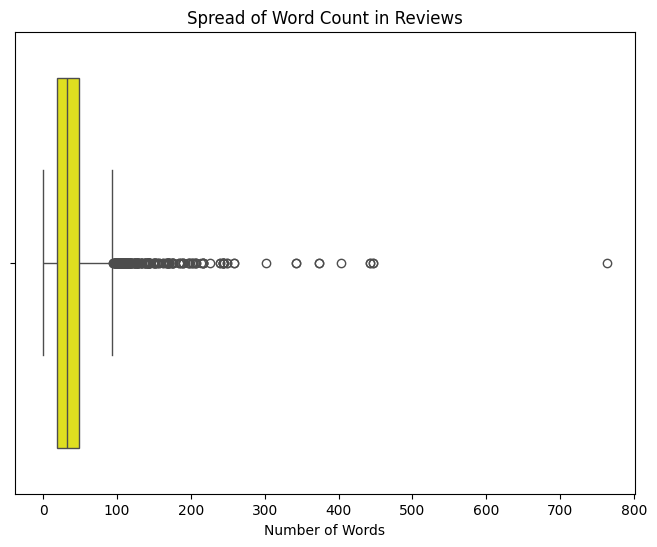

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

dataset_combined['word_count'] = dataset_combined['cleaned_review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
sns.boxplot(x=dataset_combined['word_count'], color='yellow')
plt.title('Spread of Word Count in Reviews')
plt.xlabel('Number of Words')
plt.show()

##4.2. Dataset Shape

In [ ]:
# 1. Dataset Shape
dataset_shape_df = pd.DataFrame({
    'Rows': [dataset_combined.shape[0]],
    'Columns': [dataset_combined.shape[1]]
})
print("Dataset Shape:")
display(dataset_shape_df)

# 2. Dataset
print("Dataset:")
display(dataset_combined.head())

# 3. Data Types and Missing Values
data_types_df = pd.DataFrame({
    'Column': dataset_combined.columns,
    'Data Type': dataset_combined.dtypes,
    'Missing Values': dataset_combined.isnull().sum(),
    'Missing Percentage': dataset_combined.isnull().mean() * 100
})
print("Data Types and Missing Values:")
display(data_types_df)

Dataset Shape:


,Rows,Columns
0,215063,10


Dataset:


,uniqueID,drugName,condition,review,rating,date,usefulCount,cleaned_review,ground_truth,word_count
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,try antidepressant year citalopram fluoxetine ...,positive,32
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,son crohns disease asacol complaint show effec...,positive,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,quick reduction symptom,positive,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,contrave combine drug alcohol smoke opioid ces...,positive,54
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,birth control cycle read review type similar b...,positive,53


Data Types and Missing Values:


,Column,Data Type,Missing Values,Missing Percentage
uniqueID,uniqueID,int64,0,0.000000
drugName,drugName,object,0,0.000000
condition,condition,object,1194,0.555186
review,review,object,0,0.000000
rating,rating,int64,0,0.000000
date,date,object,0,0.000000
usefulCount,usefulCount,int64,0,0.000000
cleaned_review,cleaned_review,object,0,0.000000
ground_truth,ground_truth,object,0,0.000000
word_count,word_count,int64,0,0.000000


In [ ]:
# Count missing values in each column
print("Missing values in each column:")
print(dataset_combined.isnull().sum())

Missing values in each column:
uniqueID             0
drugName             0
condition         1194
review               0
rating               0
date                 0
usefulCount          0
cleaned_review       0
ground_truth         0
word_count           0
dtype: int64


##4.3. Sentiment Distribution

Sentiment label distribution:
ground_truth
positive    129759
negative     46901
neutral      38403
Name: count, dtype: int64


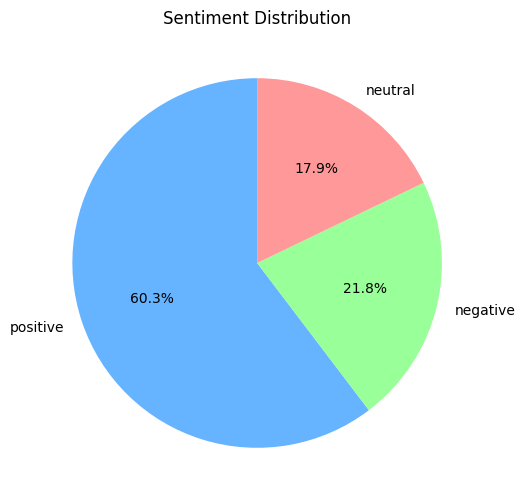

In [ ]:
# Check the distribution of sentiment labels
import matplotlib.pyplot as plt

# Check the distribution of sentiment labels
print("Sentiment label distribution:")
print(dataset_combined['ground_truth'].value_counts())

# Visualize sentiment distribution as a pie chart
sentiment_counts = dataset_combined['ground_truth'].value_counts()

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff9999'])
plt.title('Sentiment Distribution')
plt.show()

##4.4. Review column Length Analysis

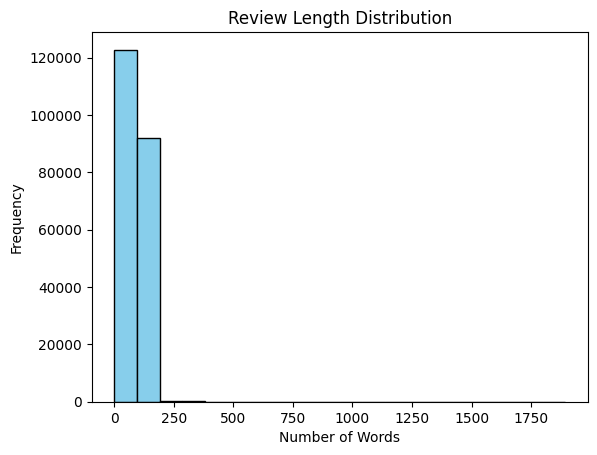

In [ ]:
# Calculate review length (number of words or characters) and add as a new column
dataset_combined['review_length'] = dataset_combined['review'].apply(lambda x: len(x.split()))

# Plot histogram of review lengths
plt.hist(dataset_combined['review_length'], bins=20, color='skyblue', edgecolor='black')
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

##4.5. Common Phrases and Bi-grams

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer to get top words for each sentiment category
vectorizer = CountVectorizer(stop_words='english', max_features=20)

for sentiment in dataset_combined['ground_truth'].unique():
    sentiment_reviews = dataset_combined[dataset_combined['ground_truth'] == sentiment]['cleaned_review']
    vectorizer.fit(sentiment_reviews)
    print(f"Most common words in {sentiment} cleaned reviews:")
    print(vectorizer.get_feature_names_out())

from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer to get top words for each sentiment category
vectorizer = CountVectorizer(stop_words='english')

for sentiment in dataset_combined['ground_truth'].unique():
    sentiment_reviews = dataset_combined[dataset_combined['ground_truth'] == sentiment]['cleaned_review']
    word_matrix = vectorizer.fit_transform(sentiment_reviews)

    # Get the sum of each word's occurrences
    word_counts = word_matrix.sum(axis=0).A1

    # Map words to their counts
    words = vectorizer.get_feature_names_out()
    word_freq = dict(zip(words, word_counts))

    # Sort words by frequency in descending order
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

    # Get the top 20 words for the current sentiment
    top_words = sorted_words[:20]

    # Print the top words for the current sentiment
    print(f"Most common words in {sentiment} cleaned reviews:")
    for word, count in top_words:
        print(f"{word}: {count}")

Most common words in positive cleaned reviews:
['bad' 'day' 'effect' 'feel' 'good' 'help' 'life' 'like' 'medication' 'mg'
 'month' 'pain' 'period' 'pill' 'start' 'time' 'try' 'week' 'work' 'year']
Most common words in neutral cleaned reviews:
['bad' 'day' 'effect' 'feel' 'gain' 'help' 'like' 'medication' 'mg'
 'month' 'pain' 'period' 'pill' 'start' 'stop' 'time' 'week' 'weight'
 'work' 'year']
Most common words in negative cleaned reviews:
['bad' 'day' 'doctor' 'effect' 'experience' 'feel' 'like' 'medication'
 'mg' 'month' 'pain' 'period' 'pill' 'start' 'stop' 'time' 'try' 'week'
 'work' 'year']
Most common words in positive cleaned reviews:
day: 77277
year: 61293
work: 56232
feel: 53519
month: 50161
effect: 47345
week: 44918
start: 44053
mg: 39075
time: 38904
pain: 37560
like: 32231
try: 31371
pill: 30593
period: 29329
help: 29195
medication: 26219
life: 25976
good: 25124
bad: 25106
Most common words in neutral cleaned reviews:
day: 24568
month: 20644
feel: 17412
start: 16065
week: 15

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(2, 2))

for sentiment in dataset_combined['ground_truth'].unique():
    sentiment_reviews = dataset_combined[dataset_combined['ground_truth'] == sentiment]['cleaned_review']
    bi_gram_matrix = vectorizer.fit_transform(sentiment_reviews)

    # Get the sum of each bi-gram's occurrences
    bi_gram_counts = bi_gram_matrix.sum(axis=0).A1

    # Map bi-grams to their counts
    bi_grams = vectorizer.get_feature_names_out()
    bi_gram_freq = dict(zip(bi_grams, bi_gram_counts))

    # Sort bi-grams by frequency in descending order
    sorted_bi_grams = sorted(bi_gram_freq.items(), key=lambda x: x[1], reverse=True)

    # Get the top 20 bi-grams for the current sentiment
    top_bi_grams = sorted_bi_grams[:20]

    # Print the top bi-grams for the current sentiment
    print(f"Most common bi-grams in {sentiment} cleaned reviews:")
    for bi_gram, count in top_bi_grams:
        print(f"{bi_gram}: {count}")

Most common bi-grams in positive cleaned reviews:
birth control: 10735
feel like: 9054
year old: 6496
weight gain: 6428
year ago: 6002
mood swing: 4698
work great: 4369
mg day: 4299
panic attack: 4191
month ago: 3646
sex drive: 3487
lose lbs: 3353
gain weight: 3243
highly recommend: 3203
lose weight: 3175
doctor prescribe: 2980
change life: 2926
lose pound: 2915
blood pressure: 2773
dry mouth: 2669
Most common bi-grams in neutral cleaned reviews:
birth control: 4546
feel like: 3278
weight gain: 2997
mood swing: 2631
sex drive: 2310
year old: 1552
gain weight: 1543
month ago: 1366
blood pressure: 1240
mg day: 1224
year ago: 1221
gain pound: 1106
lose weight: 1076
work great: 943
gain lbs: 896
period month: 880
week ago: 855
panic attack: 841
day day: 829
day feel: 823
Most common bi-grams in negative cleaned reviews:
birth control: 5783
feel like: 4978
mood swing: 3099
weight gain: 2138
sex drive: 1943
year old: 1453
gain weight: 1412
gain pound: 1328
blood pressure: 1273
month ago: 126

##4.6. Sentiment vs. Condition for Top10

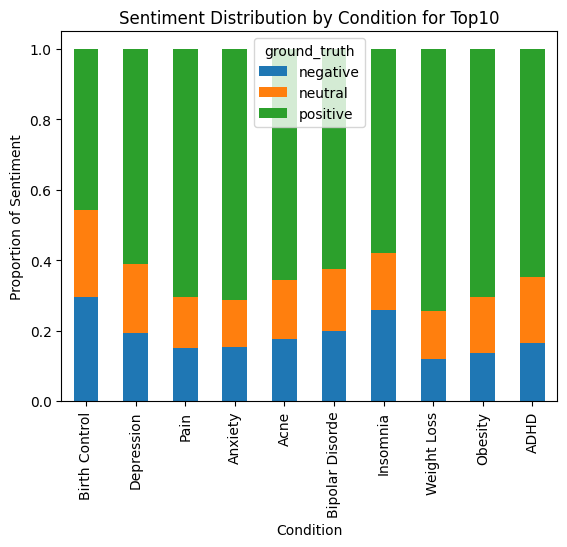

In [ ]:
# Check if the 'condition' column exists
if 'condition' in dataset_combined.columns:
    # Group by condition and sentiment, calculate normalized value counts
    sentiment_by_drug = dataset_combined.groupby('condition')['ground_truth'].value_counts(normalize=True).unstack()

    # Calculate the total number of reviews for each condition and select the top 10
    top_conditions = dataset_combined['condition'].value_counts().nlargest(10).index
    sentiment_by_drug_top10 = sentiment_by_drug.loc[top_conditions]

    # Plot the sentiment distribution for the top 10 conditions
    sentiment_by_drug_top10.plot(kind='bar', stacked=True, title='Sentiment Distribution by Condition for Top10')
    plt.xlabel('Condition')
    plt.ylabel('Proportion of Sentiment')
    plt.show()

##4.7. Sentiment Over Time

<ipython-input-21-f26ecf3493bb>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataset_combined['date'] = pd.to_datetime(dataset_combined['date'])


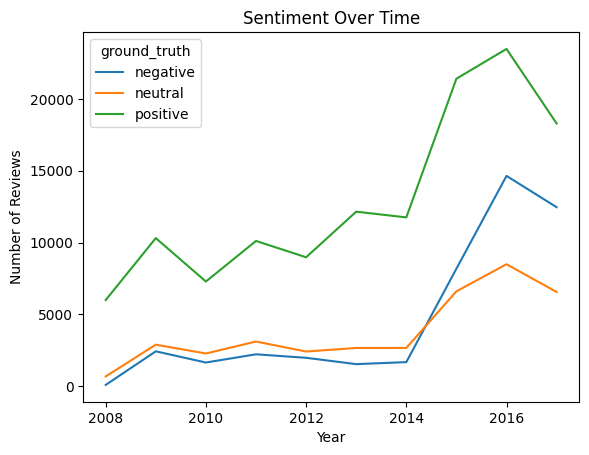

In [ ]:
# If there is a 'date' column, convert to datetime and analyze sentiment over time
if 'date' in dataset_combined.columns:
    dataset_combined['date'] = pd.to_datetime(dataset_combined['date'])
    sentiment_over_time = dataset_combined.groupby([dataset_combined['date'].dt.year, 'ground_truth']).size().unstack()
    sentiment_over_time.plot(kind='line', title='Sentiment Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Reviews')
    plt.show()

In [ ]:
!pip install wordcloud

##4.8. Wordcloud function

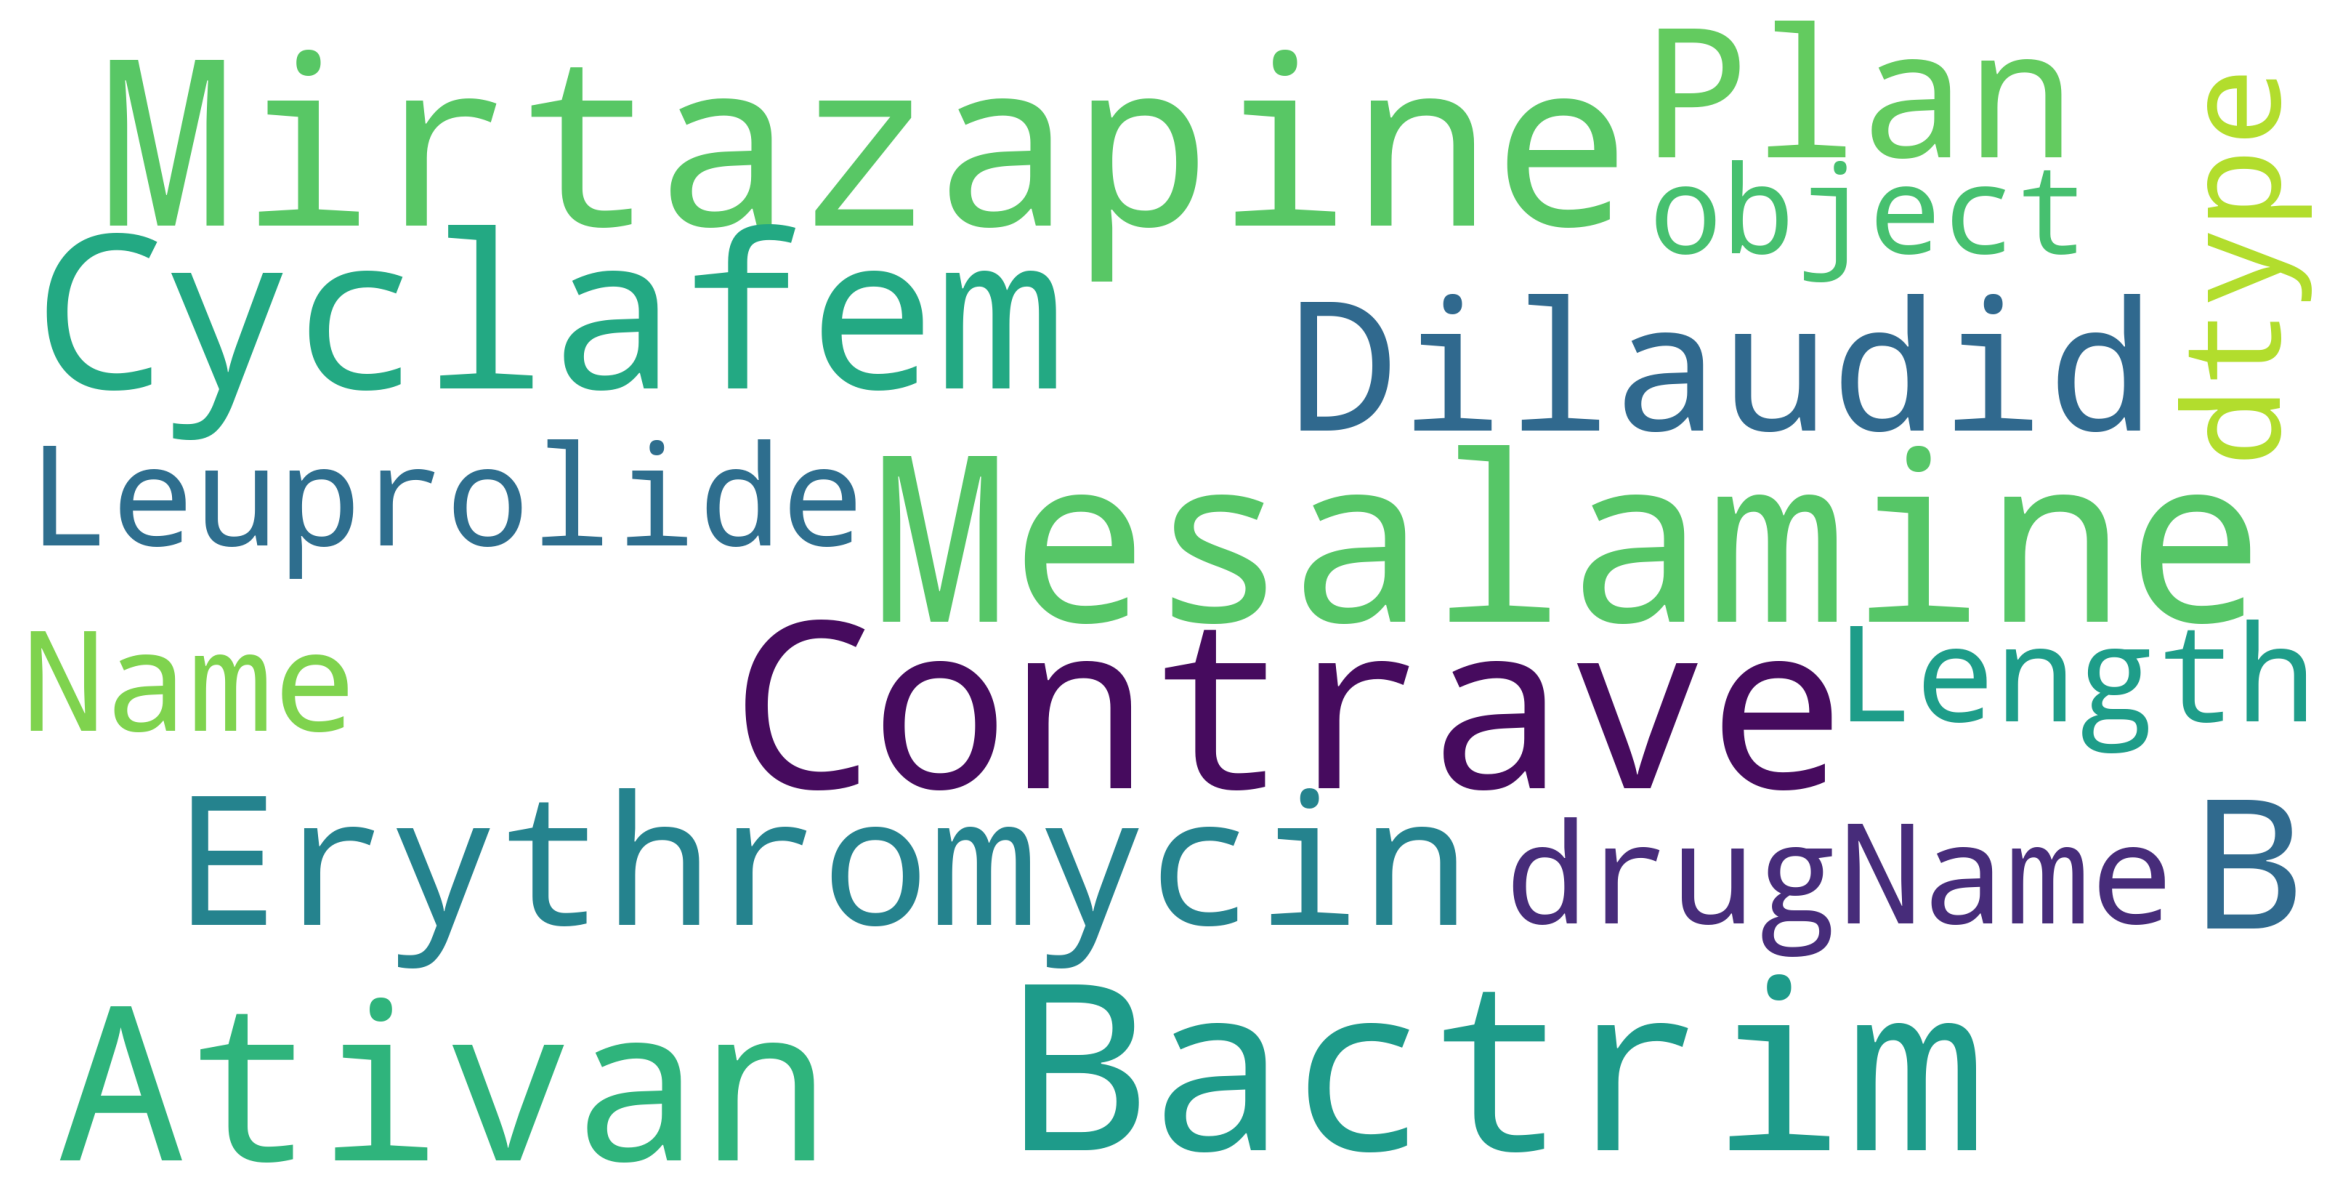

In [ ]:
# wordcloud function
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 1000,
        max_font_size = 40,
        scale = 8,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (30, 30))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# print wordcloud
show_wordcloud(dataset_combined['drugName'][:10000])

#5. Create Train/Test Set
* Shuffle and split the cleansed data into Train Set (80%)/Test Set (20%)


In [ ]:
import numpy as np

# Shuffle
dataset_combined = dataset_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Split index based on 80/20 without randomization
split_index = int(0.8 * len(dataset_combined))

train_set = dataset_combined[:split_index]
test_set = dataset_combined[split_index:]

# Preview train and test sets
print("Training Set:\n", train_set.head())
print("Test Set:\n", test_set.head())

Training Set:
    uniqueID                  drugName                  condition  \
0    120324               Montelukast                     Asthma   
1    118061                  Apixaban         Pulmonary Embolism   
2     87486                  Naproxen                       Pain   
3     53612                    Alesse  Abnormal Uterine Bleeding   
4    165053  Phentermine / topiramate                    Obesity   

                                              review  rating       date  \
0  "I was on Singulair for about a year, when my ...       7 2014-01-21   
1  "Multiple Bilateral P.E&#039;s at the age of 3...       7 2017-03-01   
2  "Gives me noticeable stomach pain on occasion ...       5 2016-09-01   
3  "This has been a complete nightmare. I always ...       1 2015-06-17   
4  "Started Qsymia 4 days ago  as part of Supervi...      10 2015-02-05   

   usefulCount                                     cleaned_review  \
0           24  singulair year medical aid sudden pay tr

In [ ]:
# Create sentiment sets
train_sentiments = (train_set['ground_truth'])
test_sentiments = (test_set['ground_truth'])
train_reviews = (train_set['cleaned_review'])
test_reviews = (test_set['cleaned_review'])

#7. Upload model_evaluation_utils.py which will be used for model evaluation of supervised and unsupervised models
* The model_evaluation_utils.py file should be placed in the Project/data/ directory within your Google Drive

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Project/data/')

import model_evaluation_utils as meu

#8. Feature Extraction

##8.1. Feature Engineering


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_set['cleaned_review'])
# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_set['cleaned_review'])

In [ ]:
# transform test reviews into features
cv_test_features = cv.transform(test_set['cleaned_review'])
tv_test_features = tv.transform(test_set['cleaned_review'])

In [ ]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (172050, 1218207)  Test features shape: (43013, 1218207)
TFIDF model:> Train features shape: (172050, 1218207)  Test features shape: (43013, 1218207)


#9. Main Functionality

##9.1 Supervised Learning Models

In [ ]:
from sklearn.linear_model import SGDClassifier, LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=500, C=1)
svm = SGDClassifier(loss='hinge', max_iter=100) # linear support vector machine

###9.1.1.Logistic Regression model on BOW features

In [ ]:
# Logistic Regression model on BOW features

lr_bow_predictions = meu.train_predict_model(classifier=lr,
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_predictions,
                                      classes=['negative', 'netral', 'positive'])

Model Performance metrics:
------------------------------
Accuracy: 0.8908
Precision: 0.8887
Recall: 0.8908
F1 Score: 0.8889

Model Classification report:
------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/me

              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      9316
      netral       0.00      0.00      0.00         0
    positive       0.91      0.95      0.93     25999

   micro avg       0.90      0.93      0.92     35315
   macro avg       0.59      0.60      0.60     35315
weighted avg       0.90      0.93      0.91     35315


Prediction Confusion Matrix:
------------------------------
                 Predicted:                
                   negative netral positive
Actual: negative       8003      0      853
        netral            0      0        0
        positive        532      0    24765


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###9.1.2. Logistic Regression model on TF-IDF features

In [ ]:
# Logistic Regression model on TF-IDF features

lr_tfidf_predictions = meu.train_predict_model(classifier=lr,
                                               train_features=tv_train_features, train_labels=train_sentiments,
                                               test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_tfidf_predictions,
                                      classes=['negative', 'neutral','positive'])

Model Performance metrics:
------------------------------
Accuracy: 0.7992
Precision: 0.7908
Recall: 0.7992
F1 Score: 0.7806

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.78      0.73      0.76      9316
     neutral       0.73      0.36      0.48      7698
    positive       0.81      0.95      0.88     25999

    accuracy                           0.80     43013
   macro avg       0.77      0.68      0.71     43013
weighted avg       0.79      0.80      0.78     43013


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   negative neutral positive
Actual: negative       6811     514     1991
        neutral        1213    2784     3701
        positive        680     540    24779


###9.1.3. Support Vector Machine model on BOW features

In [ ]:
# Support Vector Machine model on BOW features

svm_bow_predictions = meu.train_predict_model(classifier=svm,
                                             train_features=cv_train_features, train_labels=train_sentiments,
                                             test_features=cv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_bow_predictions,
                                      classes=['negative', 'neutral','positive'])

Model Performance metrics:
------------------------------
Accuracy: 0.8601
Precision: 0.8581
Recall: 0.8601
F1 Score: 0.8541

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.84      0.81      0.83      9316
     neutral       0.84      0.59      0.69      7698
    positive       0.87      0.96      0.91     25999

    accuracy                           0.86     43013
   macro avg       0.85      0.79      0.81     43013
weighted avg       0.86      0.86      0.85     43013


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   negative neutral positive
Actual: negative       7571     357     1388
        neutral         833    4569     2296
        positive        609     536    24854


###9.1.4. Support Vector Machine model on TFIDF features

In [ ]:
# Support Vector Machine model on TFIDF features

svm_tfidf_predictions = meu.train_predict_model(classifier=svm,
                                                train_features=tv_train_features, train_labels=train_sentiments,
                                                test_features=tv_test_features, test_labels=test_sentiments)
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=svm_tfidf_predictions,
                                      classes=['negative', 'neutral','positive'])

Model Performance metrics:
------------------------------
Accuracy: 0.6791
Precision: 0.7049
Recall: 0.6791
F1 Score: 0.5921

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.74      0.38      0.50      9316
     neutral       0.78      0.00      0.00      7698
    positive       0.67      0.99      0.80     25999

    accuracy                           0.68     43013
   macro avg       0.73      0.46      0.43     43013
weighted avg       0.70      0.68      0.59     43013


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   negative neutral positive
Actual: negative       3517       4     5795
        neutral         931      14     6753
        positive        322       0    25677


##9.2. Unsupervised Learning Models

###9.2.1 TextBlob Model

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob
import textblob

####9.2.1.1 Predicted Sentiment polarity with Original Review Column

In [ ]:
for i, (review, ground_truth) in enumerate(zip(test_set['review'], test_set['ground_truth'])):
    if i >= 50:  # Stop after processing 50 records
        break
    print('REVIEW:', review)
    print('Actual Sentiment:', ground_truth)
    # Compute the predicted sentiment polarity using TextBlob
    predicted_sentiment = textblob.TextBlob(review).sentiment.polarity
    print('Predicted Sentiment polarity:', predicted_sentiment)
    print('-' * 60)

REVIEW: "I have used Edex for over 3 years.  
Very positive in that it almost never fails to give me a nice hard, durable erection within a few minutes with stimulation, maybe 2 &quot;erection fails&quot; in several hundred uses.  The injections are painless and very easy to get used to. cost per dose is very small.
Not so positive is that for about 2 years I have had a difficult time reaching orgasm and when I do it often is only after very hard, intense, prolonged stimulation, almost never through intercourse alone.
Mr Urologist insists that the orgasm issue is all in my head, that the medication is giving me the erection as it is supposed to, but that there must be some other issues involved."
Actual Sentiment: positive
Predicted Sentiment polarity: 0.022516233766233778
------------------------------------------------------------
REVIEW: "I started Chateal four months ago. Bad  idea, I&#039;ve gained 20 pounds, something extremely unusual for me cause I had the same weight since I w

In [ ]:
predicted_sentiment = [textblob.TextBlob(review).sentiment.polarity for review in test_set['review']]

In [ ]:
def predicted_sentiments(predicted_sentiment):
    predicted_sentiments = []
    for score in predicted_sentiment:
        if score >= 0.01:
            predicted_sentiments.append('positive')
        elif score > 0.001:
            predicted_sentiments.append('neutral')
        else:
            predicted_sentiments.append('negative')
    return predicted_sentiments

#### 9.2.1.2 Textblob Model with Original Review Column

In [ ]:
true_labels = test_set['ground_truth'].tolist()

# Get predicted sentiments
predicted_labels = predicted_sentiments(predicted_sentiment)

# Now call the performance metrics function
meu.display_model_performance_metrics(true_labels=true_labels,
                                      predicted_labels=predicted_labels,
                                      classes=['positive', 'neutral', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.5708
Precision: 0.5461
Recall: 0.5708
F1 Score: 0.5368

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.71      0.71      0.71     25999
     neutral       0.21      0.02      0.04      7698
    negative       0.36      0.63      0.46      9316

    accuracy                           0.57     43013
   macro avg       0.43      0.46      0.40     43013
weighted avg       0.55      0.57      0.54     43013


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive neutral negative
Actual: positive      18490     444     7065
        neutral        4237     161     3300
        negative       3246     169     5901


####9.2.2.1 Predicted Sentiment polarity with Cleaned Review Column

In [ ]:
for i, (cleaned_review, ground_truth) in enumerate(zip(test_set['cleaned_review'], test_set['ground_truth'])):
    if i >= 50:  # Stop after processing 50 records
        break
    print('REVIEW:', cleaned_review)
    print('Actual Sentiment:', ground_truth)
    # Compute the predicted sentiment polarity using TextBlob
    predicted_sentiment = textblob.TextBlob(review).sentiment.polarity
    print('Predicted Sentiment polarity:', predicted_sentiment)
    print('-' * 60)

REVIEW: edex year positive fail nice hard durable erection minute stimulation maybe erection fail use injection painless easy cost dose small positive year difficult time reach orgasm hard intense prolong stimulation intercourse mr urologist insist orgasm issue head medication give erection suppose issue involve
Actual Sentiment: positive
Predicted Sentiment polarity: -0.05867768595041323
------------------------------------------------------------
REVIEW: start chateal month ago bad idea gain pound extremely unusual cause weight acne episode rare cause severe mood change tired sleepy conclusion pill suck wait change
Actual Sentiment: negative
Predicted Sentiment polarity: -0.14999999999999997
------------------------------------------------------------
REVIEW: doxycycline week bout lyme disease moderate severe drowsiness disease severe antibiotic absolutely unable stomach result nausea bad case vomiting feel well quickly take food sideeffect whatsoever good mild antibiotic
Actual Sent

In [ ]:
predicted_sentiment = [textblob.TextBlob(review).sentiment.polarity for review in test_set['cleaned_review']]

In [ ]:
def predicted_sentiments(predicted_sentiment):
    predicted_sentiments = []
    for score in predicted_sentiment:
        if score >= 0.01:
            predicted_sentiments.append('positive')
        elif score > 0.001:
            predicted_sentiments.append('neutral')
        else:
            predicted_sentiments.append('negative')
    return predicted_sentiments

####9.2.1.2 Textblob Model with Cleaned Review Column



In [ ]:
true_labels = test_set['ground_truth'].tolist()

# Get predicted sentiments
predicted_labels = predicted_sentiments(predicted_sentiment)

# Now call the performance metrics function
meu.display_model_performance_metrics(true_labels=true_labels,
                                      predicted_labels=predicted_labels,
                                      classes=['positive', 'neutral', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.5009
Precision: 0.5533
Recall: 0.5009
F1 Score: 0.499

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.74      0.55      0.63     25999
     neutral       0.20      0.09      0.12      7698
    negative       0.33      0.71      0.45      9316

    accuracy                           0.50     43013
   macro avg       0.42      0.45      0.40     43013
weighted avg       0.55      0.50      0.50     43013


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive neutral negative
Actual: positive      14244    2144     9611
        neutral        2895     676     4127
        negative       2114     576     6626


###9.2.2 Vader Model
* References:
    https://www.nltk.org/_modules/nltk/sentiment/vader.html

    https://pub.towardsai.net/fine-tuning-vader-classifier-with-domain-specific-lexicons-1b23f6882f2

In [ ]:
# Import and download libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
analyzer = SentimentIntensityAnalyzer()

####9.2.2.1 Create custom lexicon that is more domain-specific to drug reviews to expand Vader's lexicon

In [ ]:
# Custom lexicon with my manually assigned scores to be used for the polarity scores
custom_lexicon = {
    "no_side_effects": 2.0,
    "side_effects": -2.0,
    "side_effect": -1.5,
    "would_recommend": 1.5,
    "highly_recommend": 2.0,
    "much_better": 2.0,
    "minor": 0,
    "little": 0,
    "gradual": 0,
    "steady": 0,
    "adequate": 0,
    "acceptable": 0,
    "temporary": 0,
    "not_great": 0,
    "not_bad": 0,
    "slightly_better": 0,
    "mild_improvement": 0,
    "mixed_results": 0,
    "worked_somewhat": 0,
    "some_relief": 0,
    "helped_but": 0,
    "no_significant_difference": 0,
    "variable_response": 0,
    "worked_but": 0,
    "not_long-lasting": 0,
    "no_major_improvement": 0,
    "better_than_nothing": 0,
    "somewhat_useful": 0,
    "nothing_too_bad": 0,
    "no_change": 0,
    "no side effects": 2.0,
    "side effects": -2.0,
    "side effect": -1.5,
    "would recommend": 1.5,
    "highly recommend": 2.0,
    "much better": 2.0,
    "not great": 0,
    "not bad": 0,
    "slightly better": 0,
    "mild improvement": 0,
    "mixed results": 0,
    "worked somewhat": 0,
    "some relief": 0,
    "helped but": 0,
    "no significant difference": 0,
    "variable response": 0,
    "worked but": 0,
    "not long-lasting": 0,
    "no major improvement": 0,
    "better than nothing": 0,
    "somewhat useful": 0,
    "nothing too bad": 0,
    "no change": 0
}

####9.2.2.2. Build Unsupervised Model using Vader

In [ ]:
# Update Vader's lexicon with custom lexicon
analyzer.lexicon.update(custom_lexicon)

In [ ]:
def analyze_sentiment_vader_lexicon(review, threshold_pos=0.03, threshold_neg=-0.03): # adjust thresholds, this yielded best results
    # Analyze sentiment
    scores = analyzer.polarity_scores(review)
    agg_score = scores['compound']

    # Classify sentiment based on compound score and specified thresholds
    if agg_score >= threshold_pos:
        return 'positive'
    elif agg_score <= threshold_neg:
        return 'negative'
    else:
        return 'neutral'

####9.2.2.3 Create function to predict sentiments using Vader


In [ ]:
def vm_predict_sentiments(dataset, column):
    predicted_sentiments = []
    for review in dataset[column]:
        predicted_sentiments.append(analyze_sentiment_vader_lexicon(review))
    return predicted_sentiments

####9.2.2.4. Create a full copy of train and test sets to avoid SettingWithCopyWarning

In [ ]:
split_index = int(0.8 * len(dataset_combined))
train_set = dataset_combined[:split_index].copy()
test_set = dataset_combined[split_index:].copy()

####9.2.2.5. Apply Vader Model to pre-processed reviews (cleaned_review column)


In [ ]:
# Apply VADER to the test set using 'cleaned_review'
test_set['predicted_sentiment_cleaned'] = vm_predict_sentiments(test_set, 'cleaned_review')
print("Test Set (Cleaned):\n", test_set[['review', 'predicted_sentiment_cleaned', 'rating']].head())

Test Set (Cleaned):
                                                    review  \
172050  "I have used Edex for over 3 years.  \r\nVery ...   
172051  "I started Chateal four months ago. Bad  idea,...   
172052  "I&#039;ve been on doxycycline for about a wee...   
172053  "Absolutely the best method to stop, I have st...   
172054  "So I just switched to this method of bc from ...   

       predicted_sentiment_cleaned  rating  
172050                    positive       9  
172051                    negative       2  
172052                    negative       8  
172053                    positive      10  
172054                    positive       8  


In [ ]:
# Use model_evaluation_utils.py to evaluate model performance on the cleaned test set

meu.display_model_performance_metrics(true_labels=test_set['ground_truth'],
                                      predicted_labels=test_set['predicted_sentiment_cleaned'],
                                      classes=['positive', 'neutral', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.497
Precision: 0.5352
Recall: 0.497
F1 Score: 0.4867

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.72      0.56      0.63     25999
     neutral       0.17      0.04      0.07      7698
    negative       0.31      0.70      0.43      9316

    accuracy                           0.50     43013
   macro avg       0.40      0.43      0.38     43013
weighted avg       0.54      0.50      0.49     43013


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive neutral negative
Actual: positive      14509    1190    10300
        neutral        3220     339     4139
        negative       2339     447     6530


####9.2.2.6. Apply Vader Model to raw reviews (review column)

In [ ]:
# Apply VADER to the test set using 'review'
test_set['predicted_sentiment_raw'] = vm_predict_sentiments(test_set, 'review')
print("Test Set (Raw):\n", test_set[['review', 'predicted_sentiment_raw', 'rating']].head())

Test Set (Raw):
                                                    review  \
172050  "I have used Edex for over 3 years.  \r\nVery ...   
172051  "I started Chateal four months ago. Bad  idea,...   
172052  "I&#039;ve been on doxycycline for about a wee...   
172053  "Absolutely the best method to stop, I have st...   
172054  "So I just switched to this method of bc from ...   

       predicted_sentiment_raw  rating  
172050                positive       9  
172051                negative       2  
172052                negative       8  
172053                positive      10  
172054                negative       8  


In [ ]:
# Use model_evaluation_utils.py to evaluate model performance on the raw test set

meu.display_model_performance_metrics(true_labels=test_set['ground_truth'],
                                      predicted_labels=test_set['predicted_sentiment_raw'],
                                      classes=['positive', 'neutral', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.5037
Precision: 0.5431
Recall: 0.5037
F1 Score: 0.4916

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.74      0.56      0.64     25999
     neutral       0.16      0.04      0.06      7698
    negative       0.32      0.73      0.44      9316

    accuracy                           0.50     43013
   macro avg       0.40      0.44      0.38     43013
weighted avg       0.54      0.50      0.49     43013


Prediction Confusion Matrix:
------------------------------
                 Predicted:                 
                   positive neutral negative
Actual: positive      14568    1098    10333
        neutral        3066     279     4353
        negative       2081     417     6818


###9.3. Comparison of Model Approaches with Visualizations

###9.3.1.Supervised Learning Model Performance
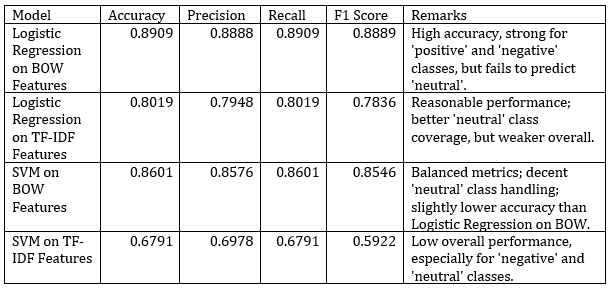


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize a dictionary to store metrics
performance_metrics = {
    'Model': [],
    'Features': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Define a function to calculate and store metrics
def collect_metrics(model_name, features, true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Append metrics to the dictionary
    performance_metrics['Model'].append(model_name)
    performance_metrics['Features'].append(features)
    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1-Score'].append(f1)

# Logistic Regression on BOW
collect_metrics('Logistic Regression', 'BOW', test_sentiments, lr_bow_predictions)

# Logistic Regression on TF-IDF
collect_metrics('Logistic Regression', 'TF-IDF', test_sentiments, lr_tfidf_predictions)

# SVM on BOW
collect_metrics('SVM', 'BOW', test_sentiments, svm_bow_predictions)

# SVM on TF-IDF
collect_metrics('SVM', 'TF-IDF', test_sentiments, svm_tfidf_predictions)

# Convert dictionary to a DataFrame for display
metrics_df = pd.DataFrame(performance_metrics)

# Display the DataFrame
print(metrics_df)


                 Model Features  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression      BOW  0.890824   0.888714  0.890824  0.888857
1  Logistic Regression   TF-IDF  0.799154   0.790836  0.799154  0.780567
2                  SVM      BOW  0.860066   0.858060  0.860066  0.854123
3                  SVM   TF-IDF  0.679051   0.704916  0.679051  0.592123


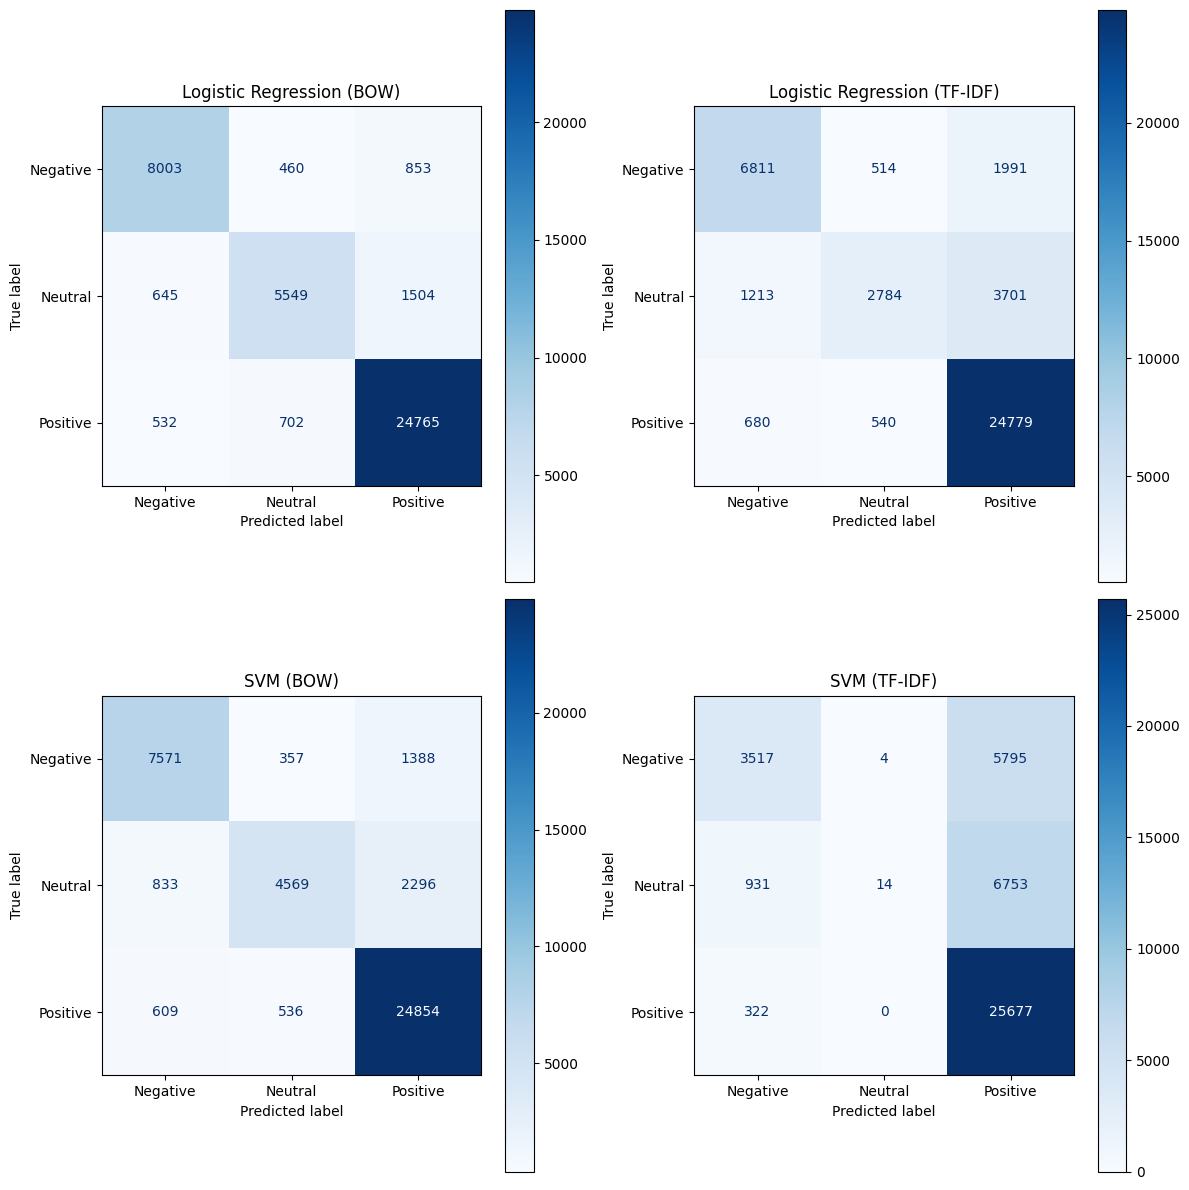

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the function to prepare and map labels
def map_labels(labels, label_mapping):
    return [label_mapping[label] for label in labels]

# Map sentiment labels to integers
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
test_sentiments_mapped = map_labels(test_sentiments, label_mapping)

# Map predictions for all models
lr_bow_predictions_mapped = map_labels(lr_bow_predictions, label_mapping)
lr_tfidf_predictions_mapped = map_labels(lr_tfidf_predictions, label_mapping)
svm_bow_predictions_mapped = map_labels(svm_bow_predictions, label_mapping)
svm_tfidf_predictions_mapped = map_labels(svm_tfidf_predictions, label_mapping)

# Create subplots for displaying all confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot Logistic Regression with BOW
cm_lr_bow = confusion_matrix(test_sentiments_mapped, lr_bow_predictions_mapped, labels=[0, 1, 2])
disp_lr_bow = ConfusionMatrixDisplay(confusion_matrix=cm_lr_bow, display_labels=['Negative', 'Neutral', 'Positive'])
disp_lr_bow.plot(ax=axes[0, 0], cmap='Blues', values_format='d')
axes[0, 0].set_title('Logistic Regression (BOW)')

# Plot Logistic Regression with TF-IDF
cm_lr_tfidf = confusion_matrix(test_sentiments_mapped, lr_tfidf_predictions_mapped, labels=[0, 1, 2])
disp_lr_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_lr_tfidf, display_labels=['Negative', 'Neutral', 'Positive'])
disp_lr_tfidf.plot(ax=axes[0, 1], cmap='Blues', values_format='d')
axes[0, 1].set_title('Logistic Regression (TF-IDF)')

# Plot SVM with BOW
cm_svm_bow = confusion_matrix(test_sentiments_mapped, svm_bow_predictions_mapped, labels=[0, 1, 2])
disp_svm_bow = ConfusionMatrixDisplay(confusion_matrix=cm_svm_bow, display_labels=['Negative', 'Neutral', 'Positive'])
disp_svm_bow.plot(ax=axes[1, 0], cmap='Blues', values_format='d')
axes[1, 0].set_title('SVM (BOW)')

# Plot SVM with TF-IDF
cm_svm_tfidf = confusion_matrix(test_sentiments_mapped, svm_tfidf_predictions_mapped, labels=[0, 1, 2])
disp_svm_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_svm_tfidf, display_labels=['Negative', 'Neutral', 'Positive'])
disp_svm_tfidf.plot(ax=axes[1, 1], cmap='Blues', values_format='d')
axes[1, 1].set_title('SVM (TF-IDF)')

# Adjust layout
plt.tight_layout()
plt.show()


###9.3.2. Unsupervised Learning Model Performance

####9.3.2.1. TextBlob Model Performance Summary

This report evaluates the performance of a sentiment analysis model applied to a dataset of 43,013 samples.

Two scenarios were analyzed:
1.   Using uncleaned reviews.
2.   Using cleaned reviews.

The goal is to assess the impact of cleaning the review column on model performance metrics, classification report, and confusion matrix.
1. Model Performance Metrics

  Metric	Uncleaned Reviews	& Cleaned Reviews
*   Accuracy	0.5708 	 0.5289
*   Precision	0.5461	0.5435
*   Recall	0.5708	0.5289
*   F1 Score	0.5368	0.5042

Observations:


*   For positive sentiments, cleaned reviews slightly improve precision but reduce recall.

*   For neutral sentiments, both precision and recall are extremely low in both cases, but uncleaned reviews perform marginally better.


*   For negative sentiments, uncleaned reviews show better F1 scores due to higher recall.

Key Insights:

1.   Uncleaned Reviews Perform Better:
  * The uncleaned reviews outperform cleaned reviews in overall accuracy, F1 score, and recall.
  *   Cleaning the text may remove important contextual information that contributes to sentiment detection.
2.  Neutral Sentiments Are Challenging:
  *  Both models struggle significantly with neutral sentiments, as evidenced by low recall and F1 scores.
  *. This indicates a need for better feature engineering or additional training data for neutral sentiment detection.
3. Positive-Negative Confusion:
  * There is notable confusion between positive and negative sentiments in both cases.
  * This suggests that the model might benefit from additional training data or more sophisticated techniques

Conclusion:
While cleaning text is often considered beneficial for sentiment analysis, this experiment demonstrates that uncleaned text can sometimes yield better results due to preserved context and richer features for classification tasks. This report provides a comprehensive comparison of the two approaches and actionable insights for improving model performance.

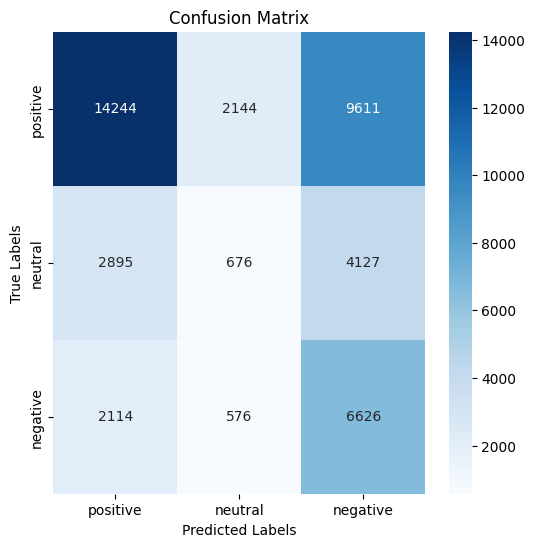

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['positive', 'neutral', 'negative'])

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

              precision    recall  f1-score   support

    positive       0.33      0.71      0.45      9316
     neutral       0.20      0.09      0.12      7698
    negative       0.74      0.55      0.63     25999

    accuracy                           0.50     43013
   macro avg       0.42      0.45      0.40     43013
weighted avg       0.55      0.50      0.50     43013



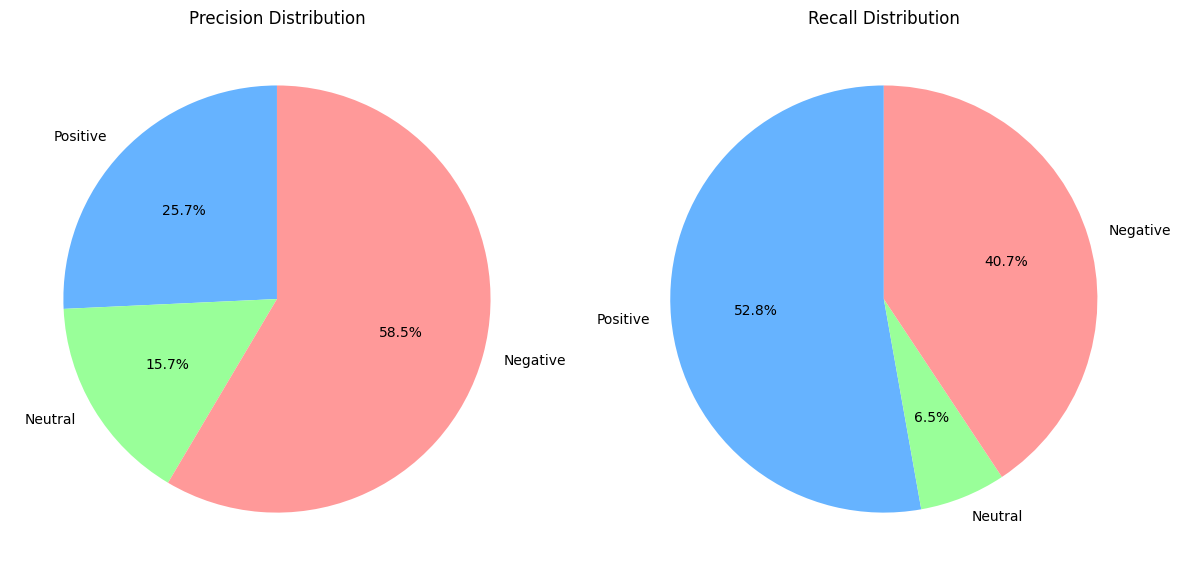

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=['positive', 'neutral', 'negative'])
print(report)

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['positive', 'neutral', 'negative'], output_dict=True)

# Extract precision and recall for each class
precision = [report['positive']['precision'], report['neutral']['precision'], report['negative']['precision']]
recall = [report['positive']['recall'], report['neutral']['recall'], report['negative']['recall']]

# Labels for the pie chart
labels = ['Positive', 'Neutral', 'Negative']

# Plot Precision Pie Chart
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(precision, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff9999'])
plt.title('Precision Distribution')

# Plot Recall Pie Chart
plt.subplot(1, 2, 2)
plt.pie(recall, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ff9999'])
plt.title('Recall Distribution')

# Show the plots
plt.tight_layout()
plt.show()

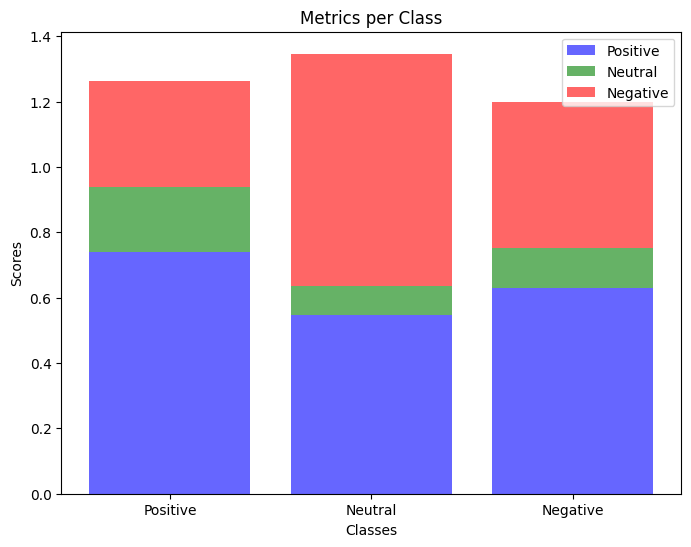

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None, labels=['positive', 'neutral', 'negative'])
recall = recall_score(true_labels, predicted_labels, average=None, labels=['positive', 'neutral', 'negative'])
f1 = f1_score(true_labels, predicted_labels, average=None, labels=['positive', 'neutral', 'negative'])

# Plot the metrics
metrics = ['Precision', 'Recall', 'F1-Score']
values_pos = [precision[0], recall[0], f1[0]]
values_neu = [precision[1], recall[1], f1[1]]
values_neg = [precision[2], recall[2], f1[2]]

x = ['Positive', 'Neutral', 'Negative']

plt.figure(figsize=(8, 6))
plt.bar(x, values_pos, alpha=0.6, label='Positive', color='blue')
plt.bar(x, values_neu, alpha=0.6, label='Neutral', color='green', bottom=values_pos)
plt.bar(x, values_neg, alpha=0.6, label='Negative', color='red', bottom=[i+j for i,j in zip(values_pos, values_neu)])

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.title('Metrics per Class')
plt.legend()
plt.show()

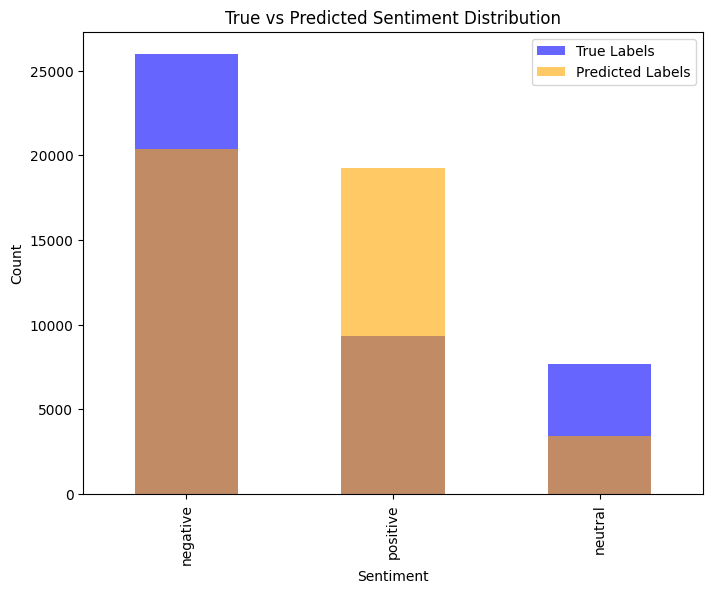

In [ ]:
# Create a DataFrame for visualization
df = pd.DataFrame({
    'True Labels': true_labels,
    'Predicted Labels': predicted_labels
})

# Count the occurrences of each class in both true and predicted labels
true_counts = df['True Labels'].value_counts()
predicted_counts = df['Predicted Labels'].value_counts()

# Plot the distribution of true vs predicted labels
plt.figure(figsize=(8, 6))
true_counts.plot(kind='bar', alpha=0.6, label='True Labels', color='blue')
predicted_counts.plot(kind='bar', alpha=0.6, label='Predicted Labels', color='orange')
plt.title('True vs Predicted Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend()
plt.show()

####9.3.2.2. Vader Model Performance (with Custom Lexicon on cleaned test set)

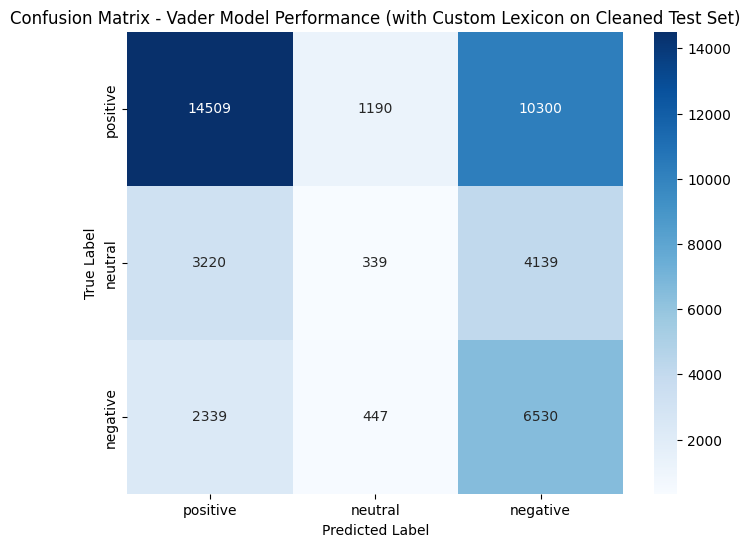

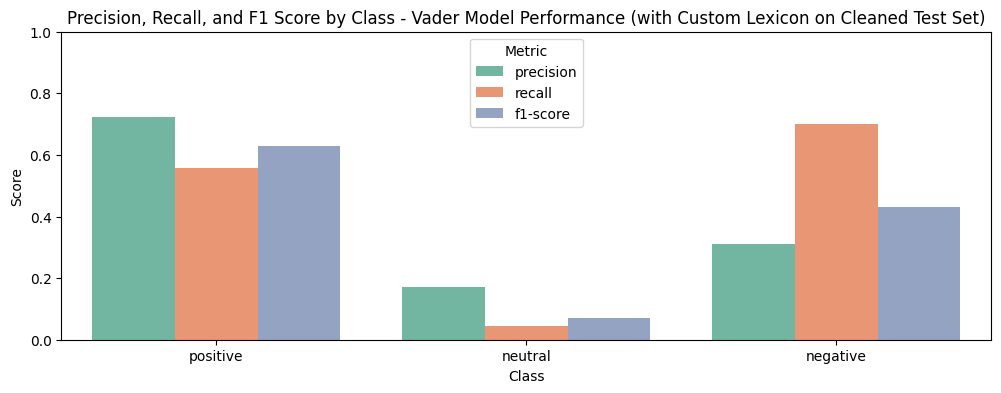

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Define true and predicted labels
true_labels = test_set['ground_truth']
predicted_labels = test_set['predicted_sentiment_cleaned']
classes = ['positive', 'neutral', 'negative']

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Vader Model Performance (with Custom Lexicon on Cleaned Test Set)')
plt.show()

# Generate the classification report as a dictionary for precision, recall, and F1 score
report = classification_report(true_labels, predicted_labels, labels=classes, output_dict=True)

# Prepare the data for bar plots by transforming it into a dataframe
metrics = ['precision', 'recall', 'f1-score']
plot_data = pd.DataFrame({
    'Class': [cls for cls in classes for _ in metrics],
    'Metric': metrics * len(classes),
    'Score': [report[cls][metric] for cls in classes for metric in metrics]
})

# Plot precision, recall, and F1 scores by class
plt.figure(figsize=(12, 4))
sns.barplot(data=plot_data, x='Class', y='Score', hue='Metric', palette="Set2")
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1 Score by Class - Vader Model Performance (with Custom Lexicon on Cleaned Test Set)')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.show()

The model achieves an accuracy of 49.7%, performing best with positive sentiments (72% precision, 56% recall) but struggling significantly with neutral (17% precision, 4% recall) and negative sentiments (31% precision, 70% recall). Positive sentiments are frequently misclassified as negative (10,299 cases), while neutral sentiments are often confused with positive or negative. Negative predictions are somewhat reliable in recall but lack precision. Overall, the model leans toward positive predictions, with room for improvement in handling neutral and negative sentiments.

####9.3.2.3 Vader Model Performance (with Custom Lexicon on raw test set)

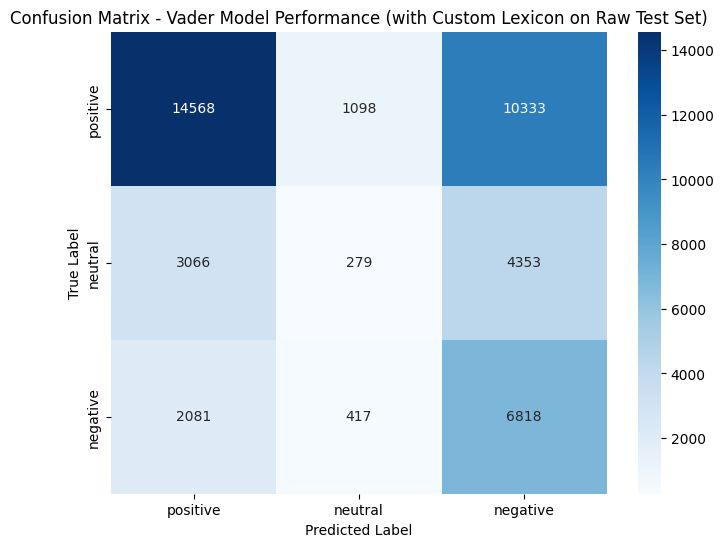

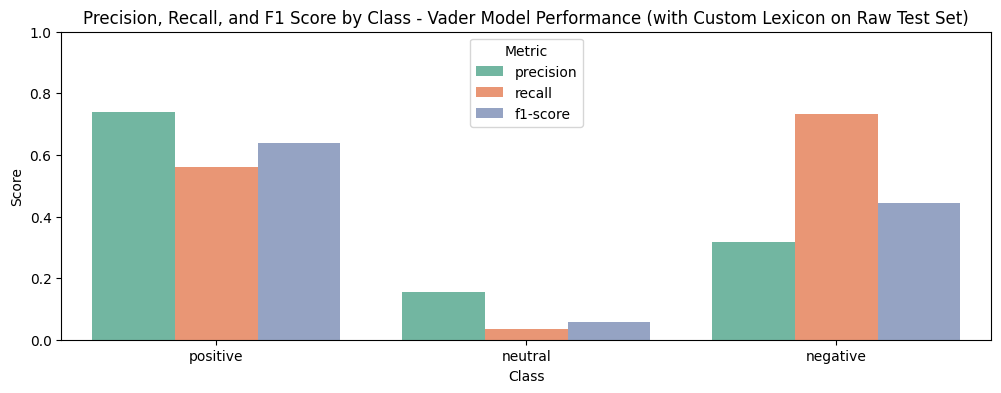

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Define true and predicted labels
true_labels = test_set['ground_truth']
predicted_labels = test_set['predicted_sentiment_raw']
classes = ['positive', 'neutral', 'negative']

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Vader Model Performance (with Custom Lexicon on Raw Test Set)')
plt.show()

# Generate the classification report as a dictionary for precision, recall, and F1 score
report = classification_report(true_labels, predicted_labels, labels=classes, output_dict=True)

# Prepare the data for bar plots by transforming it into a dataframe
metrics = ['precision', 'recall', 'f1-score']
plot_data = pd.DataFrame({
    'Class': [cls for cls in classes for _ in metrics],
    'Metric': metrics * len(classes),
    'Score': [report[cls][metric] for cls in classes for metric in metrics]
})

# Plot precision, recall, and F1 scores by class
plt.figure(figsize=(12, 4))
sns.barplot(data=plot_data, x='Class', y='Score', hue='Metric', palette="Set2")
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1 Score by Class - Vader Model Performance (with Custom Lexicon on Raw Test Set)')
plt.xlabel('Class')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.show()

The model on raw reviews achieves an accuracy of 50.37%, performing best on positive sentiments with a precision of 74% and recall of 56%, while struggling with neutral (16% precision, 4% recall) and negative sentiments (32% precision, 73% recall). Positive reviews are often misclassified as negative (10,333 cases), and neutral reviews are frequently confused with positive or negative. Negative reviews, while showing strong recall, suffer from low precision, indicating a higher rate of false positives. While slightly outperforming its performance on cleansed reviews, the results remain similar overall, highlighting the need for significant improvement in handling neutral and negative sentiments.

##9.3.3. Overall comparison of the models

The evaluation of sentiment classification using supervised models shows that Bag of Words (BOW) consistently performs better than TF-IDF. Logistic Regression (BOW) achieved the highest accuracy at 89.08% with balanced metrics across all classes. This model captures key features effectively, especially for positive and negative sentiments. Logistic Regression (TF-IDF) performed worse with an accuracy of 79.91%.

The SVM model performed well with BOW, achieving 86.01% accuracy. While strong overall, SVM with BOW slightly trailed Logistic Regression (BOW) in precision and F1-score. SVM with TF-IDF struggled the most, with an accuracy of 67.90% and an F1-score of 59.21%. These results suggest that TF-IDF is not as effective for this dataset compared to BOW.

Unsupervised models trained on uncleaned reviews outperformed those trained on cleaned reviews. The uncleaned Vader model achieved an accuracy of 50.37%, compared to 49.7% for the cleaned version. Uncleaned text retained richer contextual information, which improved classification of negative sentiments. Neutral sentiments remain difficult for all models, with extremely low precision and recall regardless of whether the text was cleaned or not. TextBlob had a similar trend, with the uncleaned version outperforming the cleaned version across most metrics. For positive sentiments, TextBlob on uncleaned reviews showed improved recall compared to its cleaned counterpart, as it preserved contextual details critical for sentiment classification. Despite this, TextBlob consistently struggled with neutral sentiments, where precision and recall remained very low.

The unsupervised models frequently confuse positive and negative sentiments. The Vader model misclassified over 10,000 positive reviews as negative in both raw and cleaned datasets. TextBlob also demonstrated significant confusion between these classes. Both models lacked the sophistication required to capture nuanced distinctions, resulting in lower overall performance for neutral and negative sentiments.

Logistic Regression (BOW) provides the best overall performance. SVM (BOW) is a close alternative with slightly less consistency. TF-IDF-based models and simpler approaches like Vader and TextBlob show lower performance across all metrics. Uncleaned reviews tend to work better, suggesting that preserving context from raw data helps with sentiment detection. Improvements are needed to handle neutral sentiments and reduce confusion between positive and negative classes. These efforts could include enhanced feature engineering, additional training data, and more advanced models capable of leveraging contextual nuances in the medical domain effectively.

#10. Personal Contribution Statement


## Joycee Berin

In Part 1, I contributed to the motivation and objective section, focusing on clearly defining the project's purpose and expected outcomes. I outlined the process flow, detailing each step from data preprocessing to model evaluation and result visualization. I identified and recommended the UCI ML Drug Review dataset as the data source and proposed the idea to employing sentiment classification through different methods (one supervised and two unsupervised [Vader and TextBlob]) where each team member can tackle a specific approach. I also proofread the project proposal to ensure clarity and coherence before submission.

In Part 2, I developed the entire data extraction code, combining datasets for analysis. I implemented the complete data preprocessing pipeline, including text cleaning, tokenization, lemmatization and batch processing. I created a function to generate the ground truth labels based on ratings and wrote the train-test split code for model evaluation. I developed the entire sentiment classification workflow for the Vader model, including integrating a custom lexicon and model evaluation. I also created visualizations for EDA (word count distribution) and model performance metrics (confusion matrices, precision, recall, and F1 scores). I also proofread and reformatted the notebook before final submission.


## Du Huynh

In Part 1, our team collaborated to develop the project outline and approaches. I played a crucial role in exploring the dataset, focusing on generating ideas for supervised models by analyzing data patterns and identifying potential applications. To facilitate team collaboration, I took responsibility for organizing and scheduling meetings, ensuring effective communication among members, and creating a shared folder to centralize resources and updates.  

In Part 2, I took the lead in initiating data exploration, including grouping data for sentiment analysis and testing preliminary models to inform the project direction. After sharing my findings with the team, we divided the work: I focused on supervised models, while Joycee and Liz concentrated on unsupervised models. My exploration of supervised models included Logistic Regression and Support Vector Machine models with BOW and TF-IDF features, as well as initial trials with XGBoost. We ultimately selected the first four models for further analysis, and I conducted initial testing to refine our approach.  

Overall, our team has worked cohesively, leveraging each member's strengths. This experience has been highly enriching, and I have learned a great deal from collaborating with my teammates.

## Elizabeth Varghese

In Part 1, I pitched in defining the motivation and objective, setting the foundation for the project's direction. I was responsible for designing the Modeling Pipeline, thoroughly defining the process flow, ensuring each step was clearly articulated for the successful implementation of the project. Additionally, I outlined the approach, incorporating references to relevant links supporting the proposal. As part of the collaborative effort, also contributed to proofreading the document with correct alignment to project's goals.

In Part 2, I led the comprehensive Exploratory Data Analysis (EDA) process to gain insights into the dataset and assess various attributes such as sentiment distribution, conditions, and overall accuracy. As part of the EDA, I also analyzed common phrases and bigrams to uncover patterns and relationships within the text data for better visualizations. Additionally, I took full responsibility for developing the entire workflow for the TextBlob model, including the implementation, performance evaluation, and model tuning. I also created detailed visualizations to assess model performance, including confusion Matrix, and calculated metrics like precision, recall, and F1 scores, to ensure a comprehensive evaluation of the model’s effectiveness.